# Exploration des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the dataset
train_data = pd.read_csv('dataset/train.csv')

In [3]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

emotionLabels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

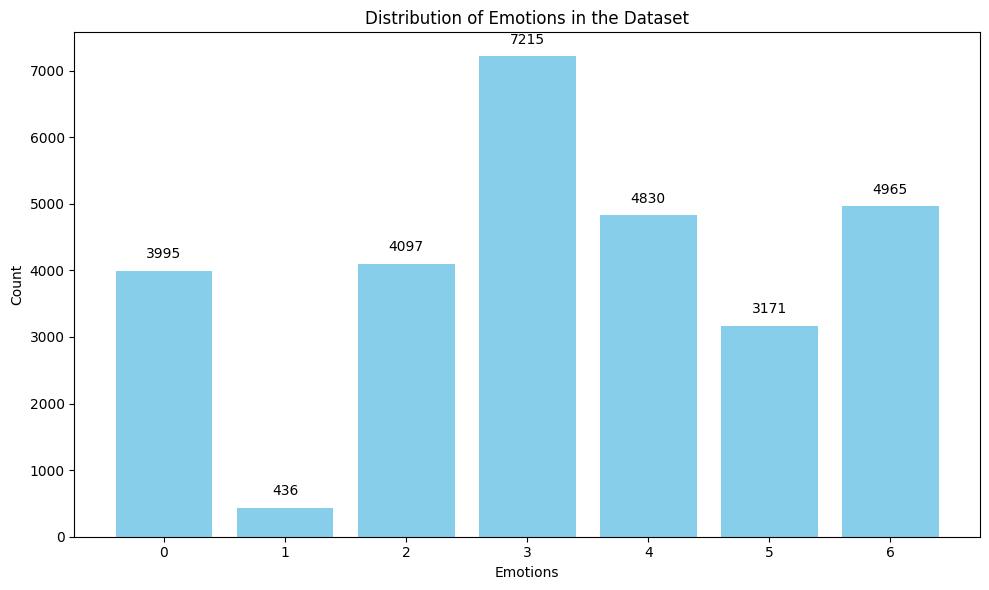

In [4]:
# Count the number of occurrences of each emotion

emotion_counts = train_data['emotion'].value_counts()

plt.figure(figsize=(10, 6))

plt.bar(emotion_counts.index, emotion_counts.values, color='skyblue')

plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions in the Dataset')

for i, count in zip(emotion_counts.index, emotion_counts.values):
    plt.text(i, count + 0.02 * max(emotion_counts.values), str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


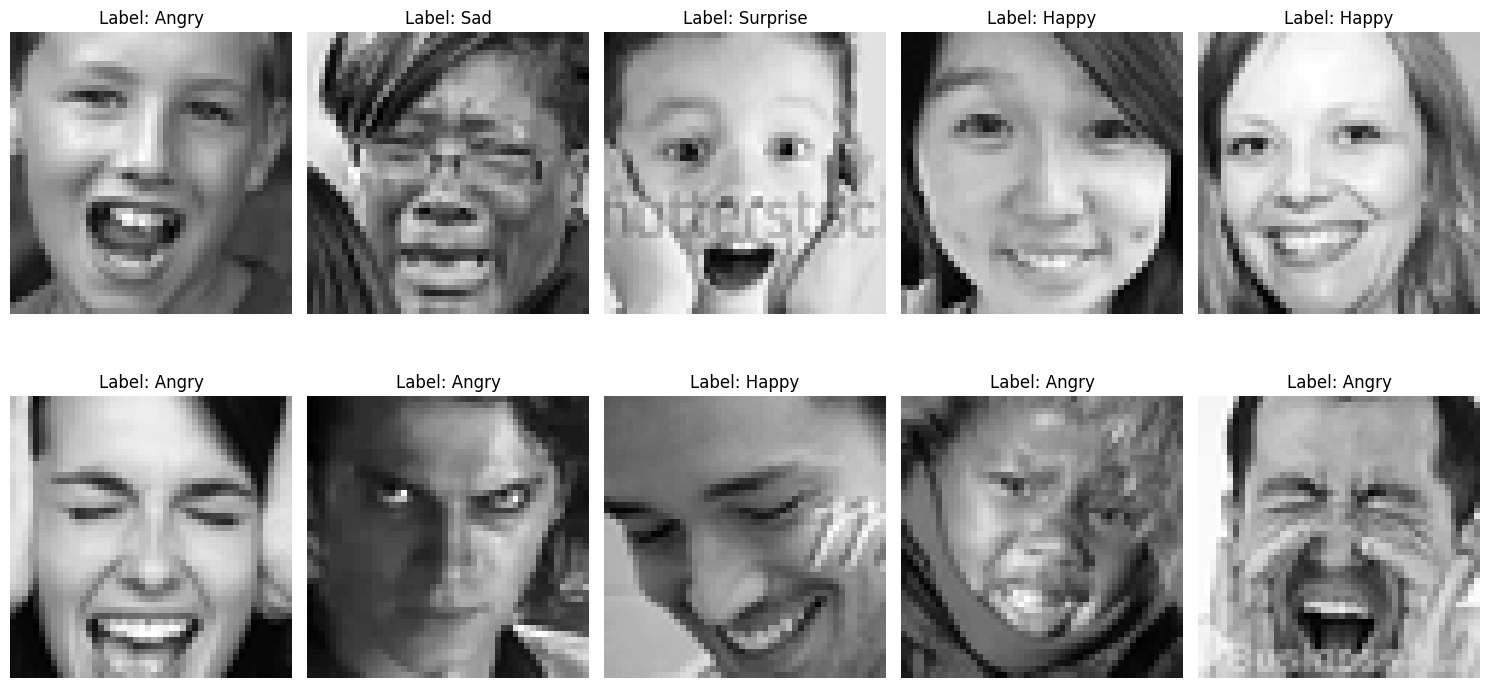

In [6]:
# Function to convert pixel string to image array
def pixels_to_image(pixels_str):
    pixels = np.array(pixels_str.split(), dtype='float32')  
    return pixels.reshape(48, 48)  # Reshape into 48x48 because the images are 48x48 pixels

# Display 10 random images
plt.figure(figsize=(15, 8))
for i in range(10):
    idx = np.random.randint(0, len(train_data))

    pixels = train_data.iloc[idx]['pixels']
    label = train_data.iloc[idx]['emotion']  

    # Convert pixels to image
    image = pixels_to_image(pixels)

    # Plot the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {emotionLabels[label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()